# Определение перспективного тарифа для телеком компании

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:
#### Тариф «Смарт»
  - Ежемесячная плата: 550 рублей
  - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
  
  Стоимость услуг сверх тарифного пакета:
  - минута разговора: 3 рубля
  - сообщение: 3 рубля
  - 1 Гб интернет-трафика: 200 рублей


#### Тариф «Ультра»

  - Ежемесячная плата: 1950 рублей
  - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
  
  Стоимость услуг сверх тарифного пакета:
  - минута разговора: 1 рубль
  - сообщение: 1 рубль
  - 1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Шаг 1. Общая информация

#### Подключаю нужные библиотеки

In [548]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from functools import reduce
from scipy import stats as st

#### Открываю таблицу users
Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

In [549]:
data_users = pd.read_csv('/datasets/users.csv')
print(data_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


Так как у нас помесячные тарифы, то добавлю столбец с меяцем регистрации.

In [550]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')
data_users['reg_month'] = pd.DatetimeIndex(data_users['reg_date']).month
data_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


#### Открываю таблицу calls
Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [551]:
data_calls = pd.read_csv('/datasets/calls.csv')
print(data_calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


In [552]:
#Выделю из даты месяц, добавлю в новый столбец
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month
data_calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12


#### Открываю таблицу internet
Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

In [553]:
data_internet = pd.read_csv('/datasets/internet.csv', index_col=0)
print(data_internet.info())
data_internet.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [554]:
print(data_internet[data_internet['mb_used'].isnull()].count())

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64


In [556]:
#Выделю из даты месяц, добавлю в новый столбец
data_internet['session_date'] = pd. to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

#### Открываю таблицу messages
Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

In [557]:
data_messages = pd.read_csv('/datasets/messages.csv')
print(data_messages.info())
data_messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [558]:
print(data_messages[data_messages['message_date'].isnull()].count())

id              0
message_date    0
user_id         0
dtype: int64


In [559]:
#Выделю из даты месяц, добавлю в новый столбец
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month

#### Открываю таблицу tariffs
Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [560]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
print(data_tariffs.info())
data_tariffs.head(10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [561]:
#Переименую столбец tariff_name в tariff
data_tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']

### Шаг 2. Подготовка данных

#### Предобработка данных

В таблице со звонками большое число нулевых значений в продолжительности звонков. Возможно это происходит потому, что абоненты вовремя не пополняют баланс sim-карт или из-за сбоев в сети. Но так-как оплата ведется поминутная, то заменю эти значения на единицу.

In [562]:
#Заменяю нулевые значения в продолжительности разговоров на значение 1
data_calls.loc[data_calls['duration'] == 0, 'duration'] = 1
data_calls['duration'].unique()

array([ 1.  ,  2.85, 13.8 , ..., 24.36, 24.5 , 26.9 ])

In [563]:
#Округлю значения в столбце "Продолжительность разговора", так как тарификация поминутная
data_calls['duration'] = np.ceil(data_calls['duration'])

In [564]:
#Заменяю нулевые значения в продолжительности интернет-сессии на значение 1
data_internet.loc[data_internet['mb_used'] == 0, 'mb_used'] = 1
data_internet['mb_used'] = np.ceil(data_internet['mb_used'])
data_internet['mb_used'].unique()

array([ 113., 1053., 1198., ..., 1540., 1346., 1388.])

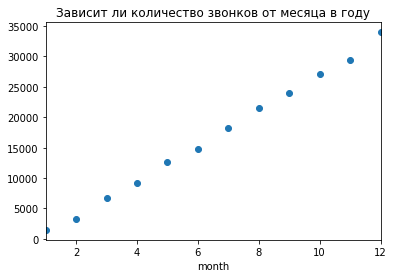

In [565]:
#Посчитаю количество сделанных звонков и израсходованных минут разговора по месяцам
count_calls_month = data_calls.groupby(['month'])['id'].count()
count_calls_month.plot(title='Зависит ли количество звонков от месяца в году', style='o')

Зависимость получилась почти линейной, по всей видимости это связано с нарастающим количеством подключенных абонентов, и соответсвенно, увеличивающемся количеством звонков.

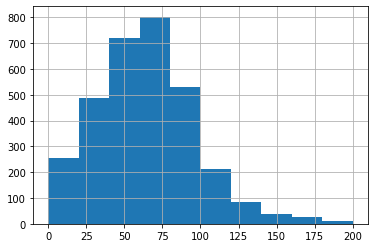

In [566]:
#Посчитаю количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
count_calls_month = data_calls.groupby(['user_id', 'month'])['id'].count()
count_calls_month.hist(range=(0, 200))

Соберу всю информацию в одной таблице, чтобы с данными было проще работать.

In [567]:
#Собираю вместе таблицы users и calls
calls_gr = data_calls.groupby(['user_id', 'month'])['duration'].sum()
calls_gr = calls_gr.reset_index(level = 'month')
users_calls = data_users.merge(calls_gr, on='user_id')
users_calls.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,month,duration
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,5,164.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,6,187.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,7,346.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,8,418.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,9,478.0


In [568]:
users_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 11 columns):
user_id       3174 non-null int64
age           3174 non-null int64
churn_date    187 non-null object
city          3174 non-null object
first_name    3174 non-null object
last_name     3174 non-null object
reg_date      3174 non-null datetime64[ns]
tariff        3174 non-null object
reg_month     3174 non-null int64
month         3174 non-null int64
duration      3174 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 297.6+ KB


In [569]:
#Собираю вместе таблицы users_calls и messages
messages_gr = data_messages.groupby(['user_id', 'month'])['id'].count()
messages_gr = messages_gr.reset_index(level = 'month')
messages_gr.columns = ['month', 'messages_count']
users_calls_messages = users_calls.merge(messages_gr, on=['user_id', 'month'], how='left')
users_calls_messages

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,month,duration,messages_count
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,5,164.0,22.0
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,6,187.0,60.0
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,7,346.0,75.0
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,8,418.0,81.0
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,9,478.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7,10,258.0,42.0
3170,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,9,9,71.0,11.0
3171,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,9,10,473.0,48.0
3172,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,9,11,624.0,59.0


In [570]:
#Собираю вместе таблицы users_calls_messages и internet
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month
internet_gr = data_internet.groupby(['user_id', 'month'])['mb_used'].sum()
internet_gr = internet_gr.reset_index(level = 'month')
internet_gr.columns = ['month', 'mb_count']
users_calls_messages_internet = users_calls_messages.merge(internet_gr, on=['user_id', 'month'], how='left')

In [598]:
#Добавляю ко всем данным таблицу tariffs
all_data = users_calls_messages_internet.merge(data_tariffs, on=['tariff'])
all_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,month,duration,messages_count,mb_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,5,164.0,22.0,2257.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,6,187.0,60.0,23262.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,7,346.0,75.0,14017.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,8,418.0,81.0,14072.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,9,478.0,57.0,14583.0,1000,30720,3000,1950,150,1,1


In [599]:
#Округляю значения в столбце 'duration', так как в тарифах предусмотрена поминутная тарификация
all_data['duration'] = np.ceil(all_data['duration'])
all_data.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,month,duration,messages_count,mb_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,5,164.0,22.0,2257.0,1000,30720,3000,1950,150,1,1
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,6,187.0,60.0,23262.0,1000,30720,3000,1950,150,1,1
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,7,346.0,75.0,14017.0,1000,30720,3000,1950,150,1,1
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,8,418.0,81.0,14072.0,1000,30720,3000,1950,150,1,1
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,9,478.0,57.0,14583.0,1000,30720,3000,1950,150,1,1


In [574]:
#Посчитаю выручку с каждого абонента
all_data['revenue'] = all_data['rub_monthly_fee'] + np.where((all_data['duration'] - all_data['minutes_included'])*all_data['rub_per_minute'] > 0, ((all_data['duration'] - all_data['minutes_included'])*all_data['rub_per_minute']), 0) 
+ np.where(((all_data['messages_count'] - all_data['messages_included'])*all_data['rub_per_message']) > 0, ((all_data['messages_count'] - all_data['messages_included'])*all_data['rub_per_message']), 0) 
+ np.where((((all_data['mb_count'] - all_data['mb_per_month_included'])/1024)*all_data['rub_per_gb']) > 0, (((all_data['mb_count'] - all_data['mb_per_month_included'])/1024)*all_data['rub_per_gb']),0)

all_data['revenue'].astype(int)  

0       1950
1       1950
2       1950
3       1950
4       1950
        ... 
3169     550
3170     550
3171     550
3172     922
3173     565
Name: revenue, Length: 3174, dtype: int64

In [575]:
#Заменяю пропущенные значения в нужных столбцах на нулевые
all_data['mb_count'] = all_data['mb_count'].fillna(value=0)
all_data['messages_count'] = all_data['messages_count'].fillna(value=0)
all_data['duration'] = all_data['duration'].fillna(value=0)

In [576]:
for col in all_data.columns: 
    print(col) 

user_id
age
churn_date
city
first_name
last_name
reg_date
tariff
reg_month
month
duration
messages_count
mb_count
messages_included
mb_per_month_included
minutes_included
rub_monthly_fee
rub_per_gb
rub_per_message
rub_per_minute
revenue


In [577]:
#Удаляю из таблицы данные, которые не будут участвовать в анализе
all_data.drop(all_data.columns[[1,2,4,5,6,8,13,14,15,16,17,18,19]],axis=1, inplace=True) 

In [578]:
for col in all_data.columns: 
    print(col) 

user_id
city
tariff
month
duration
messages_count
mb_count
revenue


In [579]:
all_data

,user_id,city,tariff,month,duration,messages_count,mb_count,revenue
0,1000,Краснодар,ultra,5,164.0,22.0,2257.0,1950.0
1,1000,Краснодар,ultra,6,187.0,60.0,23262.0,1950.0
2,1000,Краснодар,ultra,7,346.0,75.0,14017.0,1950.0
3,1000,Краснодар,ultra,8,418.0,81.0,14072.0,1950.0
4,1000,Краснодар,ultra,9,478.0,57.0,14583.0,1950.0
...,...,...,...,...,...,...,...,...
3169,1498,Владикавказ,smart,10,258.0,42.0,20614.0,550.0
3170,1499,Пермь,smart,9,71.0,11.0,1849.0,550.0
3171,1499,Пермь,smart,10,473.0,48.0,17824.0,550.0
3172,1499,Пермь,smart,11,624.0,59.0,17994.0,922.0


### Шаг 3. Анализ данных

#### Сколько минут разговора требуется пользователям в месяц

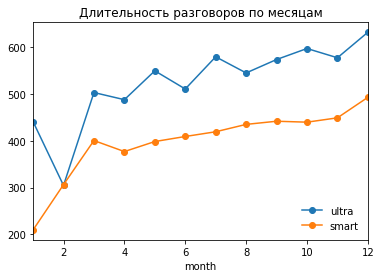

In [580]:
#Проанализирую уредненное значение длительности разговоров по месяцам
mean_duration_month_ultra = all_data.query('tariff == "ultra"')
mean_duration_month_ultra = mean_duration_month_ultra.groupby('month')['duration'].mean()
mean_duration_month_ultra.plot(title= 'Длительность разговоров по месяцам', style='o-', label = 'ultra')
mean_duration_month_smart = all_data.query('tariff == "smart"')
mean_duration_month_smart = mean_duration_month_smart.groupby('month')['duration'].mean()
mean_duration_month_smart.plot(title= 'Длительность разговоров по месяцам', style='o-', label = 'smart')
plt.legend(loc='lower right', frameon = False)

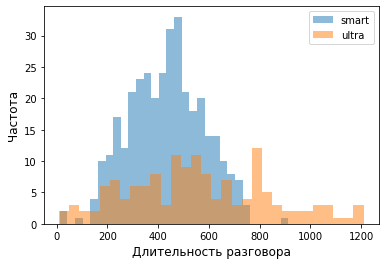

In [581]:
#Построю гистограмму для средней длительности разговоров для каждого пользователя
hist_duration_month_smart = all_data.query('tariff == "smart"')
hist_duration_month_smart = hist_duration_month_smart.groupby('user_id')['duration'].mean()
hist_duration_month_ultra = all_data.query('tariff == "ultra"')
hist_duration_month_ultra = hist_duration_month_ultra.groupby('user_id')['duration'].mean()
plt.hist(np.array(hist_duration_month_smart), histtype = 'bar', alpha = 0.5, bins=30)
plt.hist(np.array(hist_duration_month_ultra), histtype = 'bar', alpha = 0.5, bins=30)
plt.xlabel("Длительность разговора", fontsize=12)  
plt.ylabel("Частота", fontsize=12)
labels= ["smart","ultra"]
plt.legend(labels)

Длительность разговоров в зависимости от месяца в году меняется не сильно. Наибольшая длительность разговоров наблюдается в конце года.
Продолжительность разговора в зависимости от пользователя к пользователю для тарифа smart похоже на нормальное распределение, с ярко выраженным пиком.

In [582]:
#Рассчитаю среднее и медиану
avr_duration_ultra = mean_duration_month_ultra.mean()
avr_duration_smart = mean_duration_month_smart.mean()
median_duration_ultra = mean_duration_month_ultra.median()
median_duration_smart = mean_duration_month_smart.median()
#Рассчитаю дисперсию для среднего количества минут разговора
variance_estimate_duration_ultra = np.var(mean_duration_month_ultra, ddof=1)
variance_estimate_duration_smart = np.var(mean_duration_month_smart, ddof=1)
#Рассчитаю стандартное отклонение для среднего количества минут разговора
std_duration_ultra = np.sqrt(variance_estimate_duration_ultra)
std_duration_ultra = np.sqrt(variance_estimate_duration_smart)

In [583]:
duration_par = {'Параметр': ['Среднее','Медиана','Дисперсия','Стд.отклонение'],
       'Тариф Ультра': [avr_duration_ultra, median_duration_ultra, variance_estimate_duration_ultra, std_duration_ultra], 
       'Тариф Смарт': [avr_duration_smart, median_duration_smart, variance_estimate_duration_smart, std_duration_ultra]
      }

duration_param = pd.DataFrame(duration_par, columns = ['Параметр', 'Тариф Ультра', 'Тариф Смарт'])
duration_param

,Параметр,Тариф Ультра,Тариф Смарт
0,Среднее,525.068849,398.242974
1,Медиана,547.205249,414.242438
2,Дисперсия,7578.632145,5595.659947
3,Стд.отклонение,74.804144,74.804144


#### Сколько интернет-трафика требуется пользователям в месяц

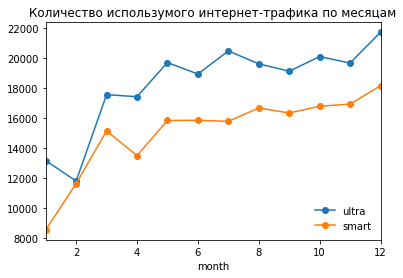

In [584]:
#Проанализирую усредненное количество использумого интернет-трафика по месяцам
mean_mb_month_ultra = all_data.query('tariff == "ultra"')
mean_mb_month_ultra = mean_mb_month_ultra.groupby('month')['mb_count'].mean()
mean_mb_month_ultra.plot(title= 'Количество использумого интернет-трафика по месяцам', style='o-', label = 'ultra')
mean_mb_month_smart = all_data.query('tariff == "smart"')
mean_mb_month_smart = mean_mb_month_smart.groupby('month')['mb_count'].mean()
mean_mb_month_smart.plot(title= 'Количество использумого интернет-трафика по месяцам', style='o-', label = 'smart')
plt.legend(loc='lower right', frameon = False)

(0, 50)

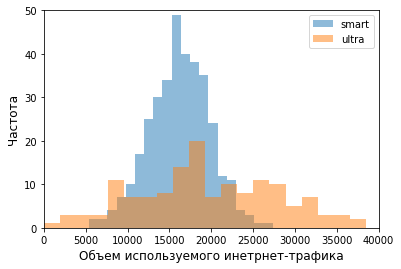

In [585]:
#Построю гистограмму для интернет-услуг для обоих тарифов
hist_mb_month_smart = all_data.query('tariff == "smart"')
hist_mb_month_smart = hist_mb_month_smart.groupby('user_id')['mb_count'].mean()
hist_mb_month_ultra = all_data.query('tariff == "ultra"')
hist_mb_month_ultra = hist_mb_month_ultra.groupby('user_id')['mb_count'].mean()


plt.hist(np.array(hist_mb_month_smart), histtype = 'bar', alpha = 0.5, bins=20)
plt.hist(np.array(hist_mb_month_ultra), histtype = 'bar', alpha = 0.5, bins=20)
plt.xlabel("Объем используемого инетрнет-трафика", fontsize=12)  
plt.ylabel("Частота", fontsize=12)
labels= ["smart","ultra"]
plt.legend(labels)
plt.xlim(0, 40000)
plt.ylim(0, 50)

Количество использованного интернет-трафика в зависимости от месяца в году незначительно растет. Наибольшая интернет-активность наблюдается в конце года.
Объем используемого интернет-трафика в зависимости от пользователя к пользователю для тарифа smart похоже на нормальное распределение, с ярко выраженным пиком.

In [586]:
#Рассчитаю среднее и медиану
avr_mb_ultra = mean_mb_month_ultra.mean().round()
avr_mb_smart = mean_mb_month_smart.mean().round()
median_mb_ultra = mean_mb_month_ultra.median().round()
median_mb_smart = mean_mb_month_smart.median().round()
#Рассчитаю дисперсию для среднего количества Мб интернет-трафика в месяц
variance_estimate_mb_ultra = np.var(mean_mb_month_ultra, ddof=1)
variance_estimate_mb_smart = np.var(mean_mb_month_smart, ddof=1)
#Рассчитаю стандартное отклонение для среднего количества Мб интернет-трафика в месяц
std_mb_ultra = np.sqrt(variance_estimate_mb_ultra)
std_mb_ultra = np.sqrt(variance_estimate_mb_smart)

In [587]:
mb_par = {'Параметр': ['Среднее','Медиана','Дисперсия','Стд.отклонение'],
       'Тариф Ультра': [avr_mb_ultra, median_mb_ultra, variance_estimate_mb_ultra, std_mb_ultra], 
       'Тариф Смарт': [avr_mb_smart, median_mb_smart, variance_estimate_mb_smart, std_mb_ultra]
      }

mb_param = pd.DataFrame(mb_par, columns = ['Параметр', 'Тариф Ультра', 'Тариф Смарт'])
mb_param

,Параметр,Тариф Ультра,Тариф Смарт
0,Среднее,1.826700e+04,1.508800e+04
1,Медиана,1.936300e+04,1.583800e+04
2,Дисперсия,8.760882e+06,7.167704e+06
3,Стд.отклонение,2.677257e+03,2.677257e+03


#### Сколько сообщений требуется пользователям в месяц

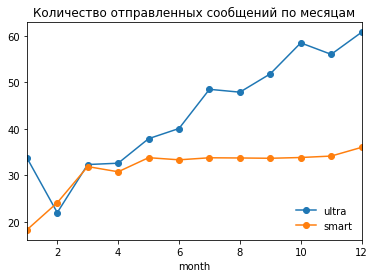

In [588]:
#Проанализирую усредненное количество отправленных сообщений по месяцам
mean_messages_month_ultra = all_data.query('tariff == "ultra"')
mean_messages_month_ultra = mean_messages_month_ultra.groupby('month')['messages_count'].mean()
mean_messages_month_ultra.plot(title= 'Количество отправленных сообщений по месяцам', style='o-', label = 'ultra')
mean_messages_month_smart = all_data.query('tariff == "smart"')
mean_messages_month_smart = mean_messages_month_smart.groupby('month')['messages_count'].mean()
mean_messages_month_smart.plot(title= 'Количество отправленных сообщений по месяцам', style='o-', label = 'smart')
plt.legend(loc='lower right', frameon = False)

(0, 70)

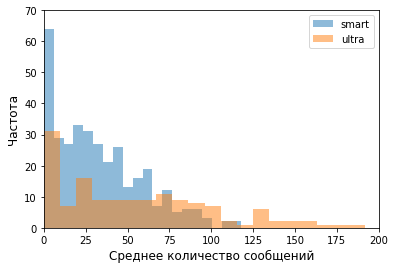

In [589]:
#Построю гистограмму для сообщений для обоих тарифов
hist_messages_month_smart = all_data.query('tariff == "smart"')
hist_messages_month_smart = hist_messages_month_smart.groupby('user_id')['messages_count'].mean()
hist_messages_month_ultra = all_data.query('tariff == "ultra"')
hist_messages_month_ultra = hist_messages_month_ultra.groupby('user_id')['messages_count'].mean()


plt.hist(np.array(hist_messages_month_smart), histtype = 'bar', alpha = 0.5, bins=20)
plt.hist(np.array(hist_messages_month_ultra), histtype = 'bar', alpha = 0.5, bins=20)
plt.xlabel("Среднее количество сообщений", fontsize=12)  
plt.ylabel("Частота", fontsize=12)
labels= ["smart","ultra"]
plt.legend(labels)
plt.xlim(0, 200)
plt.ylim(0, 70)

Довольно много клиентов не пользуются смс-ками вообще. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f0f3dfdd0>]],
      dtype=object)

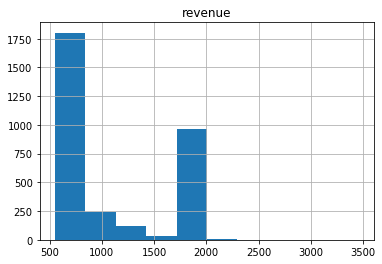

In [590]:
all_data.hist('revenue')

In [591]:
#Опрделеяю какой тариф приносит большую прибыль компании
all_ultra_revenue = all_data.query('tariff == "ultra"').sum()
all_smart_revenue = all_data.query('tariff == "smart"').sum()

if all_ultra_revenue['revenue'] > all_smart_revenue['revenue']:
    print("Тариф Ультра приносит больший суммарный доход компании")
else: 
    print("Тариф Смарт приносит больший суммарный доход компании")

Тариф Ультра приносит больший суммарный доход компании


В целом клиенты тарифных планов платят фиксированную абонентскую плату, укладываясь в лимит ограничений. Наибольшее количество клиентов платят по тарифу Смарт фиксированную сумму 550 рублей. Небольшое количество клиентов переплачивают сверх нормы тарифа.
Однако при всем при этом, больший суммарный доход компании приносит тариф Ультра.

In [592]:
all_data.query('tariff == "ultra"').revenue.describe()

count     951.0
mean     1950.0
std         0.0
min      1950.0
25%      1950.0
50%      1950.0
75%      1950.0
max      1950.0
Name: revenue, dtype: float64

In [593]:
#Рассчитаю среднее и медиану
avr_messages_ultra = mean_messages_month_ultra.mean().round()
avr_messages_smart = mean_messages_month_smart.mean().round()
median_messages_ultra = mean_messages_month_ultra.median().round()
median_messages_smart = mean_messages_month_smart.median().round()
#Рассчитаю дисперсию для среднего количества сообщений в месяц
variance_estimate_messages_ultra = np.var(mean_messages_month_ultra, ddof=1)
variance_estimate_messages_smart = np.var(mean_messages_month_smart, ddof=1)
#Рассчитаю стандартное отклонение для среднего количества сообщений в месяц
std_messages_ultra = np.sqrt(variance_estimate_messages_ultra)
std_messages_smart = np.sqrt(variance_estimate_messages_smart)

In [594]:

messages_par = {'Параметр': ['Среднее','Медиана','Дисперсия','Стд.отклонение'],
       'Тариф Ультра': [avr_messages_ultra, median_messages_ultra, variance_estimate_messages_ultra, std_messages_ultra], 
       'Тариф Смарт': [avr_messages_smart, median_messages_smart, variance_estimate_messages_smart, std_messages_smart]
      }

messages_param = pd.DataFrame(messages_par, columns = ['Параметр', 'Тариф Ультра', 'Тариф Смарт'])
messages_param

,Параметр,Тариф Ультра,Тариф Смарт
0,Среднее,43.000000,31.000000
1,Медиана,44.000000,34.000000
2,Дисперсия,148.885531,26.087992
3,Стд.отклонение,12.201866,5.107641


### Шаг 4. Проверка гипотез

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

#### Проверяю гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [595]:
mean_revenue_ultra = all_data.query('tariff == "ultra"')
mean_revenue_ultra = mean_revenue_ultra.groupby('user_id')['revenue'].mean()

mean_revenue_smart = all_data.query('tariff == "smart"')
mean_revenue_smart = mean_revenue_smart.groupby('user_id')['revenue'].mean()

alpha = .05 
results = st.ttest_ind(
    mean_revenue_ultra, 
    mean_revenue_smart)  

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.563428396005183e-245
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

#### Проверяю гипотезу:  cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [596]:
all_data['city'].unique()

array(['Краснодар', 'Москва', 'Новокузнецк', 'Иваново', 'Омск', 'Уфа',
       'Томск', 'Санкт-Петербург', 'Тверь', 'Ярославль', 'Тюмень',
       'Ростов-на-Дону', 'Калуга', 'Тула', 'Волгоград', 'Саранск',
       'Иркутск', 'Череповец', 'Новосибирск', 'Брянск', 'Тольятти',
       'Нижний Тагил', 'Воронеж', 'Махачкала', 'Пермь', 'Сургут', 'Пенза',
       'Мурманск', 'Набережные Челны', 'Самара', 'Нижний Новгород',
       'Кемерово', 'Кострома', 'Оренбург', 'Магнитогорск', 'Астрахань',
       'Нижневартовск', 'Челябинск', 'Курган', 'Красноярск',
       'Владивосток', 'Смоленск', 'Владимир', 'Казань', 'Саратов',
       'Севастополь', 'Рязань', 'Екатеринбург', 'Стерлитамак',
       'Ульяновск', 'Балашиха', 'Барнаул', 'Киров', 'Сочи', 'Вологда',
       'Чебоксары', 'Чита', 'Петрозаводск', 'Хабаровск', 'Ставрополь',
       'Улан-Удэ', 'Курск', 'Якутск', 'Химки', 'Владикавказ', 'Ижевск',
       'Орёл', 'Белгород', 'Архангельск', 'Липецк', 'Волжский', 'Тамбов',
       'Калининград', 'Новороссий

In [597]:
mean_revenue_moscow = all_data.query('city == "Москва"')
mean_revenue_moscow = mean_revenue_moscow.groupby('user_id')['revenue'].mean()

mean_revenue_other = all_data.query('tariff != "Москва"')
mean_revenue_other = mean_revenue_other.groupby('user_id')['revenue'].mean()

alpha = .05 
results = st.ttest_ind(
    mean_revenue_moscow, 
    mean_revenue_other)  

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.593917941708844
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, с вероятностью в 59% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средней выручкой из разных городов.

### Шаг 5. Общий вывод

Клиентам предлагались два тарифных плана: «Смарт» и «Ультра».
В этом проекте коммерческий департамент хотел понять, какой тариф приносит больше денег, чтобы скорректировать рекламный бюджет.
Входные данные - небольшая выборка клиентов «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно было проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Входные данные содержались в пяти таблицах. 
Была проведена предобработка данных: обработка пропусков, удаление некорректных значений. Посчитала и добавила в таблицу дополнительные параметры. Сделала сводную таблицу со всеми необходимыми данными. 

Длительность разговоров в зависимости от месяца в году меняется не сильно. Наибольшая длительность разговоров наблюдается в конце года.
В среднем клиенты отправляют 30-40 сообщений в месяц, правда, разброс по значениям здесь довольно большой: кто-то не пользуется этой услугой вовсе. Тариф Ультра приносит больший суммарный доход компании.

Провела статистический анализ и проверку двух гипотез:
1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. Гипотеза подтвердилась, полученное значение p-value позволило сделать вывод о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Гипотеза не подтвердилась, полученное значение p-value позволило сделать вывод о том, что хотя cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, с вероятностью в 34% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средней выручкой из разных городов.

